In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
data = pd.read_pickle('../datasets/train_processed.pickle')

In [3]:
# getting data for model

X_t = data['question_titles'].values.copy()
X_q = data['questions'].values.copy()
X_a = data['answers'].values.copy()

In [4]:
X_t.shape, X_q.shape, X_a.shape

((6076,), (6076,), (6076,))

In [5]:
# padding to maximum length

X_t = keras.preprocessing.sequence.pad_sequences(X_t)
X_q = keras.preprocessing.sequence.pad_sequences(X_q)
X_a = keras.preprocessing.sequence.pad_sequences(X_a)

In [6]:
X_t.shape, X_q.shape, X_a.shape

((6076, 32), (6076, 500), (6076, 500))

In [7]:
target_names = data.columns[3:-3].copy()

y = data[data.columns[3:-3]].values.copy()
y.shape

(6076, 30)

In [8]:
# train test split
from sklearn.model_selection import train_test_split

X_t_train, X_t_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2, random_state=42)
X_q_train, X_q_test, y_train, y_test = train_test_split(X_q, y, test_size=0.2, random_state=42)
X_a_train, X_a_test, y_train, y_test = train_test_split(X_a, y, test_size=0.2, random_state=42)

# Baseline model

Mean of each target feature as prediction + some noise to be able to compute correlations.

In [9]:
means = []
for i in range(y_train.shape[1]):
    x = np.mean(y_train[:,i])
    noise_factor = 0.05*x
    array = []
    for j in range(len(y_test)):
        noise = np.random.normal()*noise_factor
        array.append(x+noise)
    array = np.array(array)
    array = np.clip(array, 0 ,1)
    means.append(array)
                
means = np.array(means).T
means.shape

(1216, 30)

In [10]:
lens = []
for i in target_names:
    lens.append(len(i))
max(lens)

37

In [9]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error as mse

def print_cors_mse(target_names, preds, reals):
    cors = []
    mses = []
    for i in range(len(target_names)):
        name = target_names[i]
        name = name + ':'
        if len(name)<40:
            name = name + ' '*(40-len(name))
        print(name, f'cor: {np.round(spearmanr(preds[:,i],reals[:,i]).correlation,3)},    mse: {np.round(mse(preds[:,i],reals[:,i]),3)}')
        cors.append(spearmanr(preds[:,i],reals[:,i]).correlation)
        mses.append(mse(preds[:,i],reals[:,i]))
    print('\n\n CORRELATION STATS: \n', pd.Series(cors).describe())
    print('\n\n MSE STATS: \n', pd.Series(mses).describe())

In [12]:
print_cors_mse(target_names, means, y_test)

question_asker_intent_understanding:     cor: -0.004,    mse: 0.019
question_body_critical:                  cor: 0.008,    mse: 0.049
question_conversational:                 cor: -0.014,    mse: 0.035
question_expect_short_answer:            cor: 0.016,    mse: 0.126
question_fact_seeking:                   cor: 0.01,    mse: 0.092
question_has_commonly_accepted_answer:   cor: 0.005,    mse: 0.119
question_interestingness_others:         cor: 0.046,    mse: 0.02
question_interestingness_self:           cor: 0.051,    mse: 0.035
question_multi_intent:                   cor: 0.073,    mse: 0.112
question_not_really_a_question:          cor: 0.011,    mse: 0.002
question_opinion_seeking:                cor: 0.012,    mse: 0.139
question_type_choice:                    cor: -0.01,    mse: 0.139
question_type_compare:                   cor: -0.038,    mse: 0.031
question_type_consequence:               cor: -0.02,    mse: 0.005
question_type_definition:                cor: 0.066,    mse: 

In [10]:
def plot_cors_mse(target_names, preds, reals):
    cors = []
    mses = []
    for i in range(len(target_names)):
        cors.append(spearmanr(preds[:,i],reals[:,i]).correlation)
        mses.append(mse(preds[:,i],reals[:,i]))
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.bar(target_names, cors)
    plt.xticks(rotation=90)
    plt.title('CORS')
    plt.subplot(1,2,2)
    plt.bar(target_names, mses)
    plt.xticks(rotation=90)
    plt.title('MSEs')

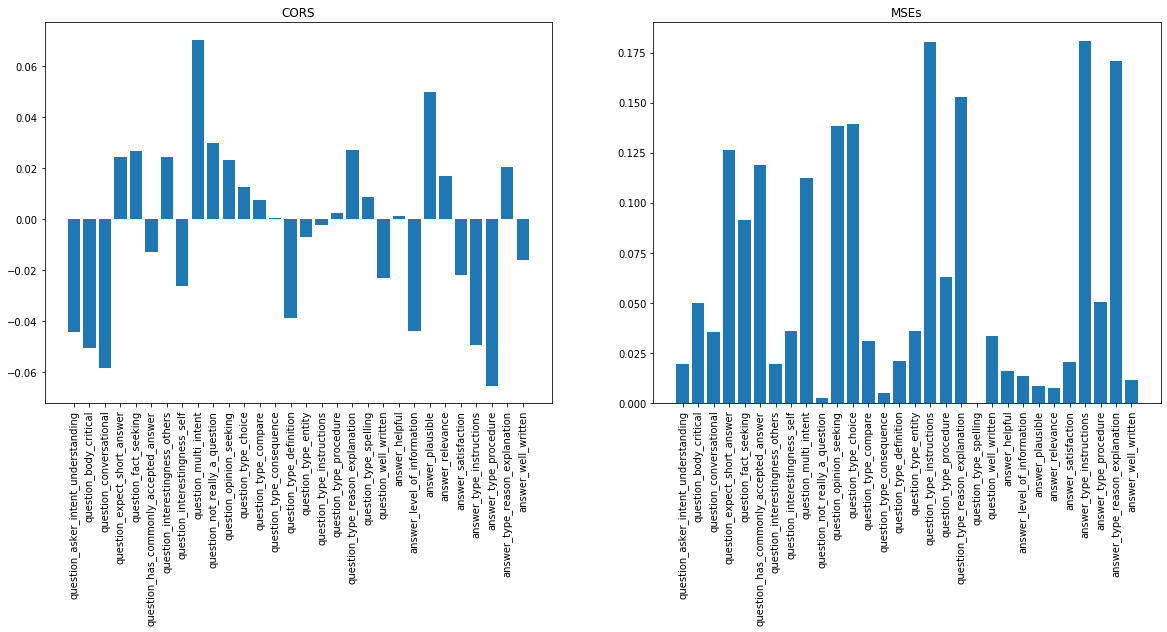

In [15]:
plot_cors_mse(target_names, means, y_test)

# Bag of words model

In [15]:
# reading data
import pickle

with open('../datasets/tfidf_inputs.pickle', 'rb') as f:
    X_bow = pickle.load(f)

In [16]:
X_bow.shape

(6076, 8277)

In [17]:
X_bow_train, X_bow_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

In [46]:
# minmax layer

class min_max_scaler(keras.layers.Layer):
    def call(self,x):
        min_ = tf.reduce_min(x)
        max_ = tf.reduce_max(x)
        
        x = (x-min_)/(max_-min_)
        return x

In [58]:
# Multilayer perceptron
# hard sigmoid for 0-1 range

model = keras.models.Sequential()

model.add(keras.layers.Input(shape = X_bow_train.shape[1]))

model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(5000, activity_regularizer='l2', activation=keras.activations.swish))

model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1000, activity_regularizer='l2', activation=keras.activations.swish))

model.add(keras.layers.Dense(30, activation=keras.activations.hard_sigmoid))
#model.add(min_max_scaler())

model.compile(optimizer = 'adam', loss = 'mse')

In [17]:
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=20, restore_best_weights=True)

In [50]:
# ideal batch size

0.03*len(X_bow_train)

145.79999999999998

In [59]:
model.fit(X_bow_train, y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=(X_bow_test, y_test))

Epoch 1/500
34/34 [==============================] - 1s 36ms/step - loss: 0.1238 - val_loss: 0.0880
Epoch 2/500
34/34 [==============================] - 1s 33ms/step - loss: 0.0803 - val_loss: 0.0724
Epoch 3/500
34/34 [==============================] - 1s 33ms/step - loss: 0.0691 - val_loss: 0.0664
Epoch 4/500
34/34 [==============================] - 1s 29ms/step - loss: 0.0631 - val_loss: 0.0631
Epoch 5/500
34/34 [==============================] - 1s 29ms/step - loss: 0.0592 - val_loss: 0.0616
Epoch 6/500
34/34 [==============================] - 1s 33ms/step - loss: 0.0566 - val_loss: 0.0606
Epoch 7/500
34/34 [==============================] - 1s 29ms/step - loss: 0.0549 - val_loss: 0.0599
Epoch 8/500
34/34 [==============================] - 1s 29ms/step - loss: 0.0536 - val_loss: 0.0596
Epoch 9/500
34/34 [==============================] - 1s 29ms/step - loss: 0.0525 - val_loss: 0.0598
Epoch 10/500
34/34 [==============================] - 1s 29ms/step - loss: 0.0518 - val_loss: 0.0594

In [60]:
preds_train = model.predict(X_bow_train)

In [61]:
preds_test = model.predict(X_bow_test)

In [62]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.194,    mse: 0.017
question_body_critical:                  cor: 0.401,    mse: 0.041
question_conversational:                 cor: 0.375,    mse: 0.029
question_expect_short_answer:            cor: 0.159,    mse: 0.121
question_fact_seeking:                   cor: 0.278,    mse: 0.079
question_has_commonly_accepted_answer:   cor: 0.357,    mse: 0.094
question_interestingness_others:         cor: 0.347,    mse: 0.017
question_interestingness_self:           cor: 0.43,    mse: 0.029
question_multi_intent:                   cor: 0.327,    mse: 0.101
question_not_really_a_question:          cor: -0.006,    mse: 0.005
question_opinion_seeking:                cor: 0.317,    mse: 0.121
question_type_choice:                    cor: 0.426,    mse: 0.116
question_type_compare:                   cor: 0.276,    mse: 0.029
question_type_consequence:               cor: 0.041,    mse: 0.007
question_type_definition:                cor: 0.252,    mse: 0

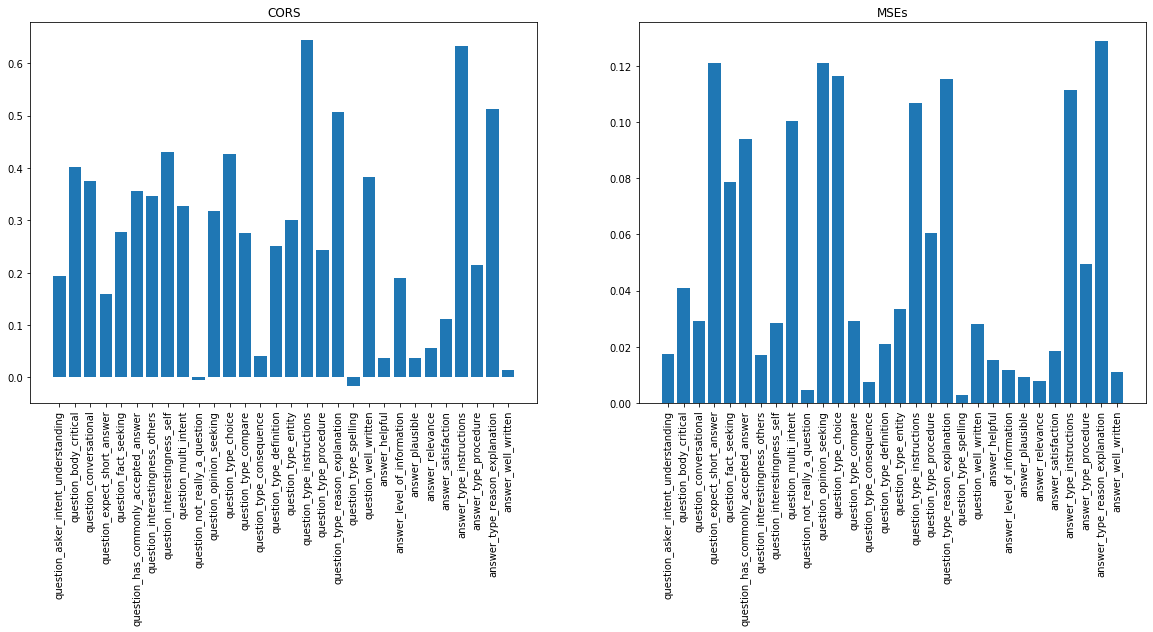

In [63]:
plot_cors_mse(target_names, preds_test, y_test)

In [11]:
# scatterplots

def scatterplots(target_names, preds, reals):
    plt.figure(figsize=(25,35))
    for i in range(len(target_names)):
        plt.subplot(10,3,i+1)
        plt.scatter(preds[:,i],reals[:,i])
        plt.title(target_names[i])
        plt.tight_layout()
    plt.show()

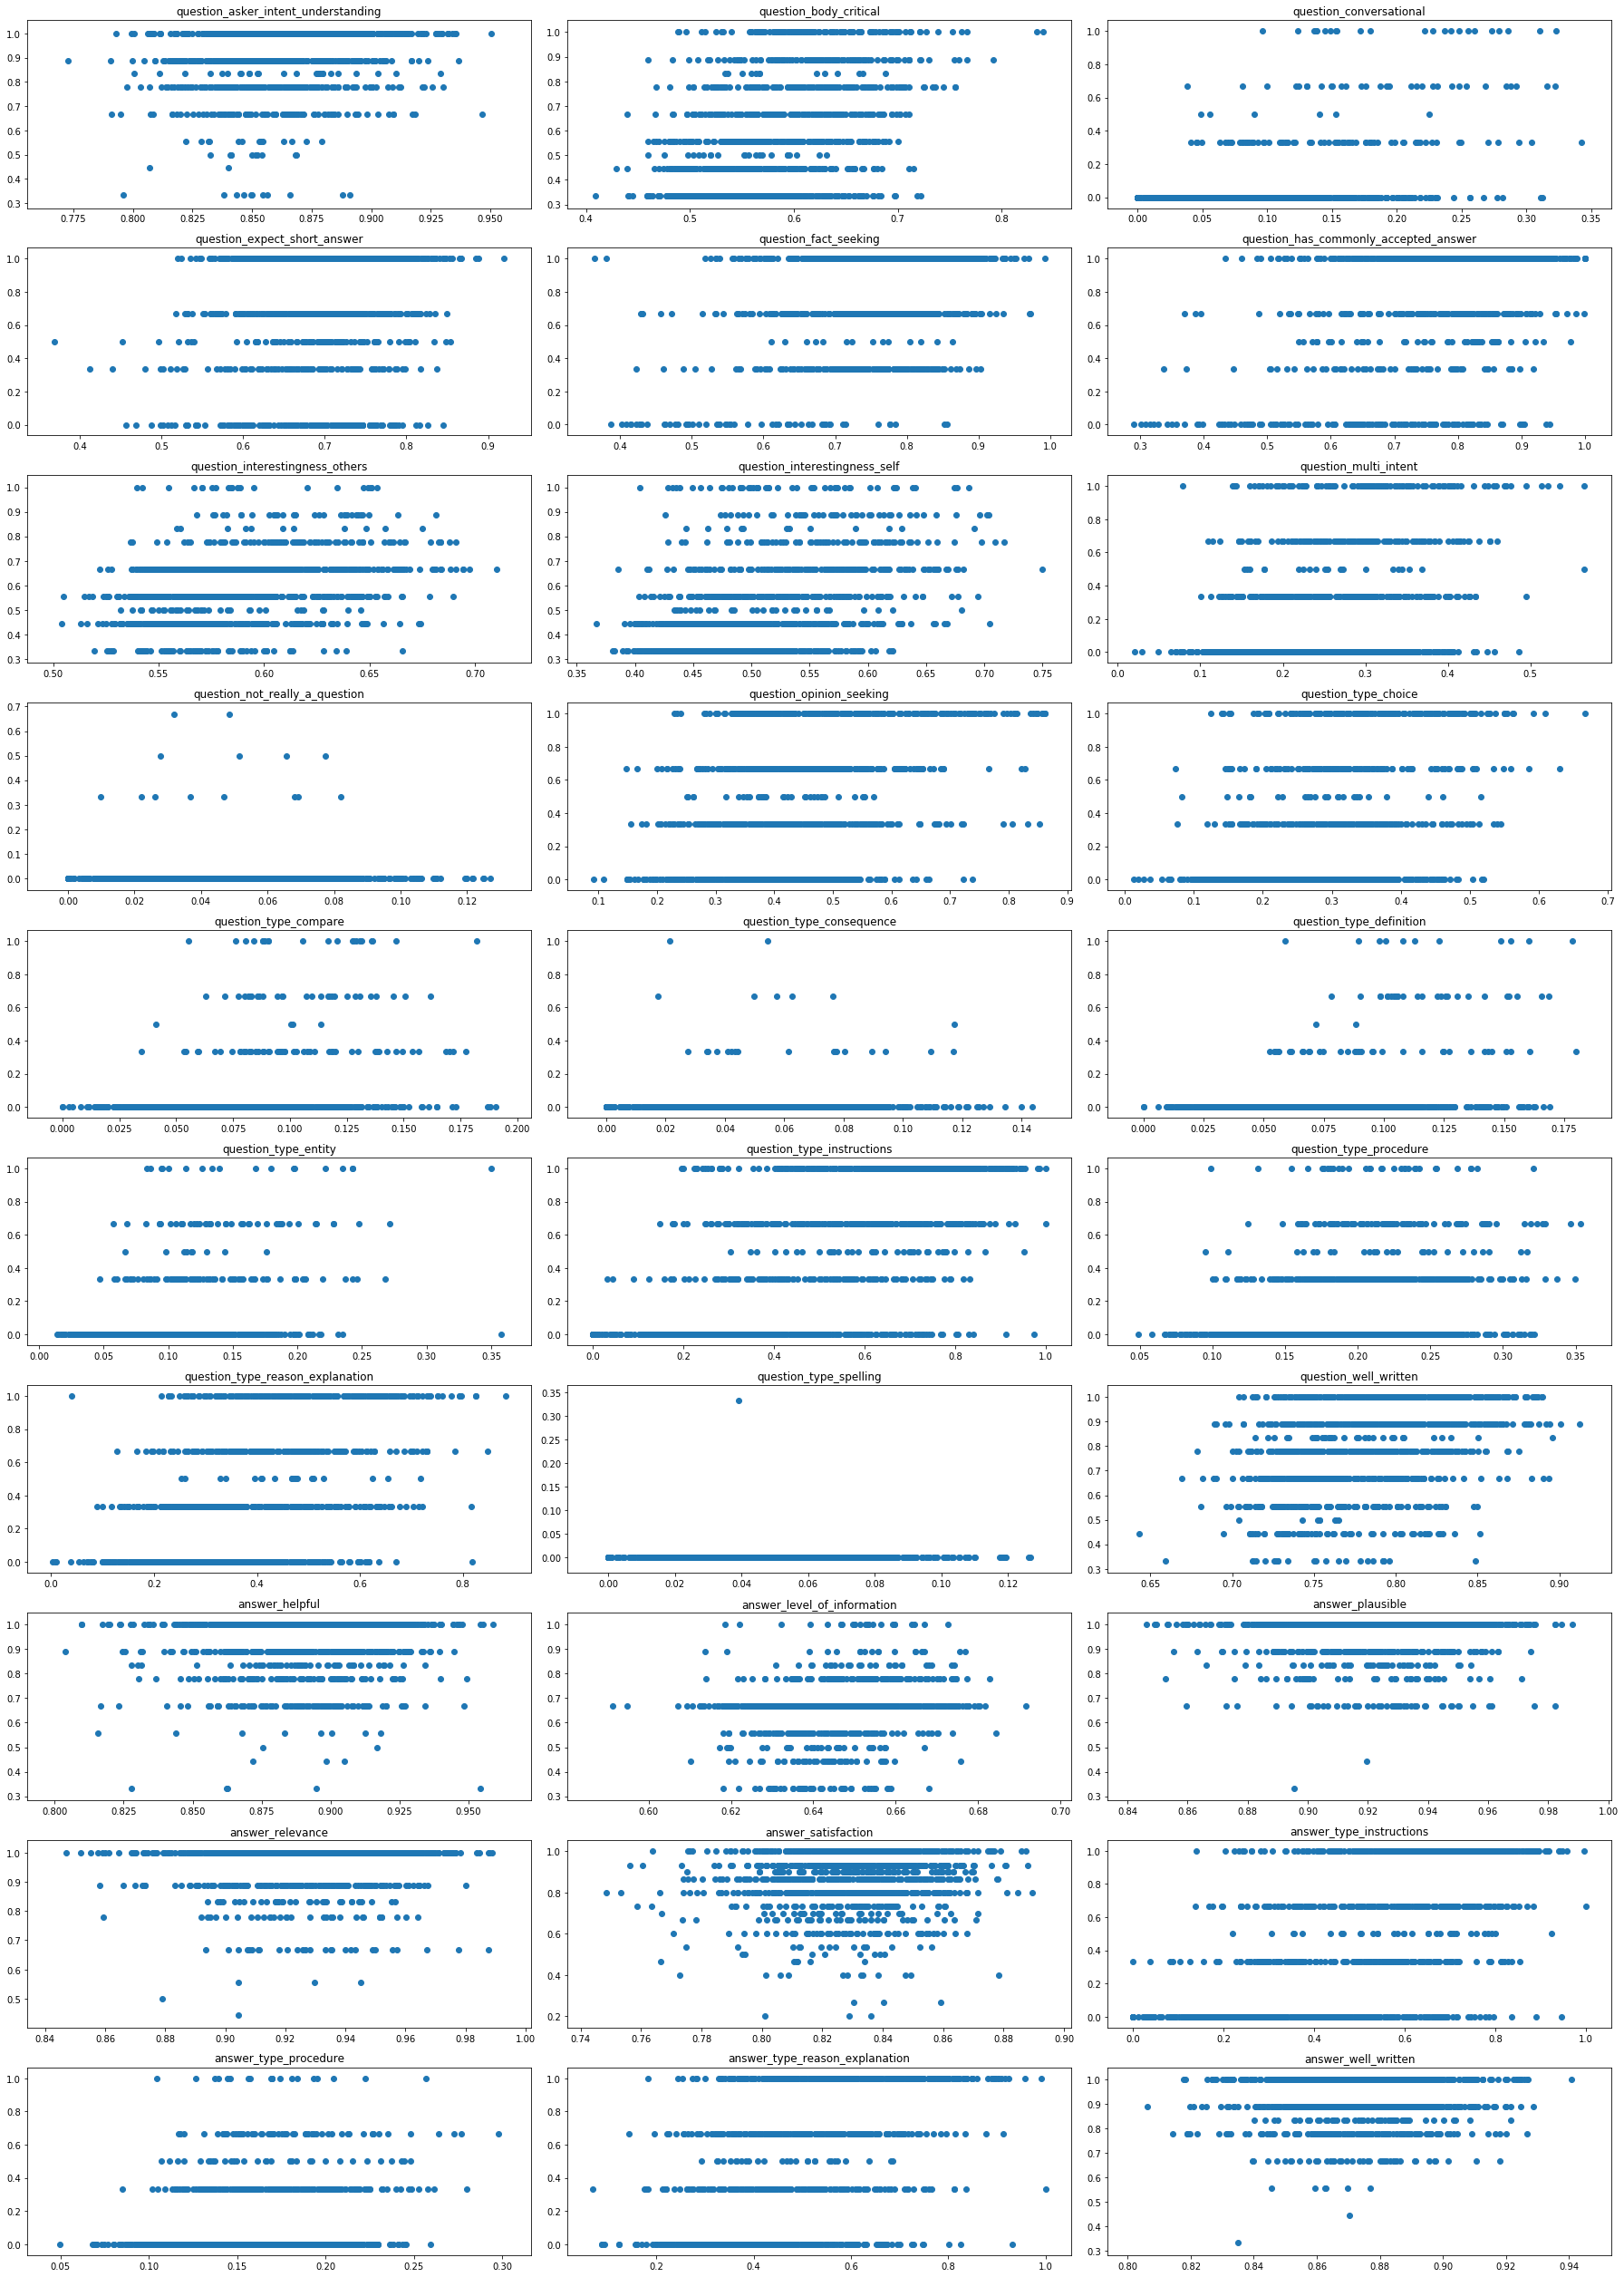

In [65]:
scatterplots(target_names, preds_test, y_test)

# LSTM Model

Not able to outperform BOW model. Probably because of own embeddings. Embeddings are huge set of weights which is hard to train, here it probably remains very stohastic.

In [12]:
X_q_train.shape, X_a_train.shape

((4860, 500), (4860, 500))

In [51]:
embedding = keras.layers.Embedding(8277, 64)
#embedding2 = keras.layers.Embedding(8277, 64)


input_q = keras.layers.Input(shape=500)
x_q = embedding(input_q)
x_q = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(x_q)

input_a = keras.layers.Input(shape=500)
x_a = embedding(input_a)
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(x_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(64, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [52]:
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 500, 64)      529728      input_20[0][0]                   
                                                                 input_21[0][0]                   
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, 128)          66048       embedding_10[0][0]   

In [53]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 6s 166ms/step - loss: 0.1528 - val_loss: 0.1391
Epoch 2/500
34/34 [==============================] - 5s 144ms/step - loss: 0.1259 - val_loss: 0.1152
Epoch 3/500
34/34 [==============================] - 5s 144ms/step - loss: 0.1058 - val_loss: 0.0997
Epoch 4/500
34/34 [==============================] - 5s 144ms/step - loss: 0.0929 - val_loss: 0.0901
Epoch 5/500
34/34 [==============================] - 5s 147ms/step - loss: 0.0841 - val_loss: 0.0840
Epoch 6/500
34/34 [==============================] - 5s 147ms/step - loss: 0.0777 - val_loss: 0.0798
Epoch 7/500
34/34 [==============================] - 5s 144ms/step - loss: 0.0729 - val_loss: 0.0767
Epoch 8/500
34/34 [==============================] - 5s 143ms/step - loss: 0.0690 - val_loss: 0.0744
Epoch 9/500
34/34 [==============================] - 5s 143ms/step - loss: 0.0659 - val_loss: 0.0727
Epoch 10/500
34/34 [==============================] - 5s 144ms/step - loss: 0.0633 - val_lo

In [54]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [55]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.114,    mse: 0.017
question_body_critical:                  cor: 0.33,    mse: 0.042
question_conversational:                 cor: 0.317,    mse: 0.033
question_expect_short_answer:            cor: 0.132,    mse: 0.126
question_fact_seeking:                   cor: 0.229,    mse: 0.084
question_has_commonly_accepted_answer:   cor: 0.247,    mse: 0.104
question_interestingness_others:         cor: 0.267,    mse: 0.018
question_interestingness_self:           cor: 0.347,    mse: 0.031
question_multi_intent:                   cor: 0.329,    mse: 0.1
question_not_really_a_question:          cor: -0.023,    mse: 0.008
question_opinion_seeking:                cor: 0.293,    mse: 0.126
question_type_choice:                    cor: 0.436,    mse: 0.116
question_type_compare:                   cor: 0.207,    mse: 0.03
question_type_consequence:               cor: 0.05,    mse: 0.01
question_type_definition:                cor: 0.185,    mse: 0.022


In [56]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.354,    mse: 0.016
question_body_critical:                  cor: 0.476,    mse: 0.037
question_conversational:                 cor: 0.448,    mse: 0.026
question_expect_short_answer:            cor: 0.653,    mse: 0.08
question_fact_seeking:                   cor: 0.647,    mse: 0.062
question_has_commonly_accepted_answer:   cor: 0.691,    mse: 0.066
question_interestingness_others:         cor: 0.381,    mse: 0.016
question_interestingness_self:           cor: 0.497,    mse: 0.026
question_multi_intent:                   cor: 0.678,    mse: 0.071
question_not_really_a_question:          cor: 0.055,    mse: 0.008
question_opinion_seeking:                cor: 0.821,    mse: 0.062
question_type_choice:                    cor: 0.678,    mse: 0.087
question_type_compare:                   cor: 0.258,    mse: 0.022
question_type_consequence:               cor: 0.111,    mse: 0.011
question_type_definition:                cor: 0.277,    mse: 0.

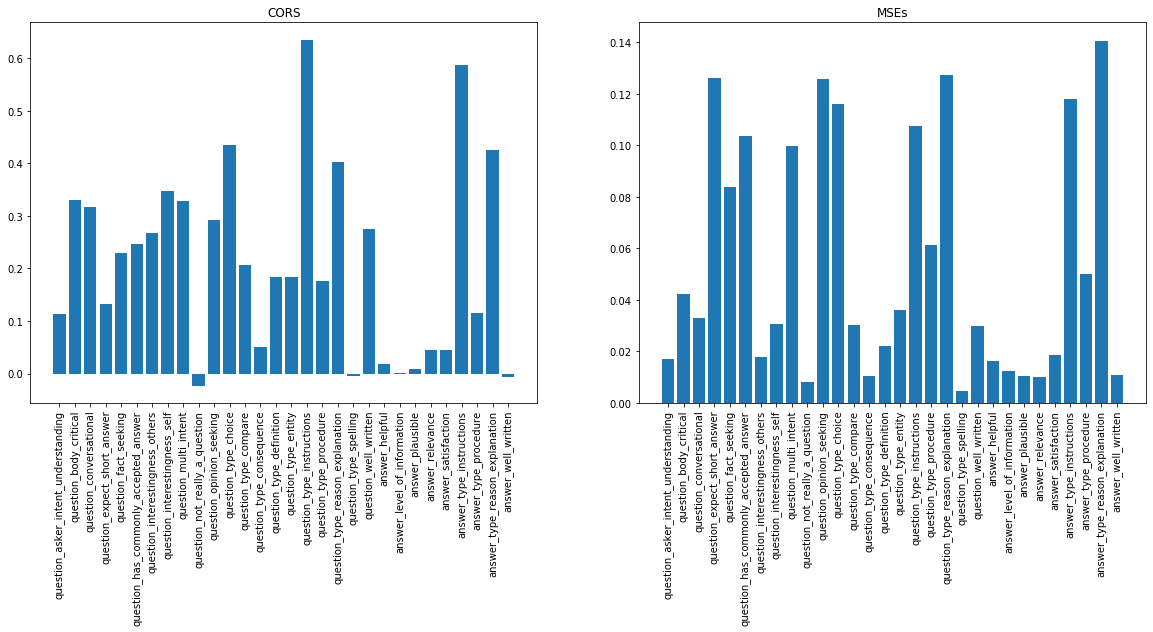

In [57]:
plot_cors_mse(target_names, preds_test, y_test)

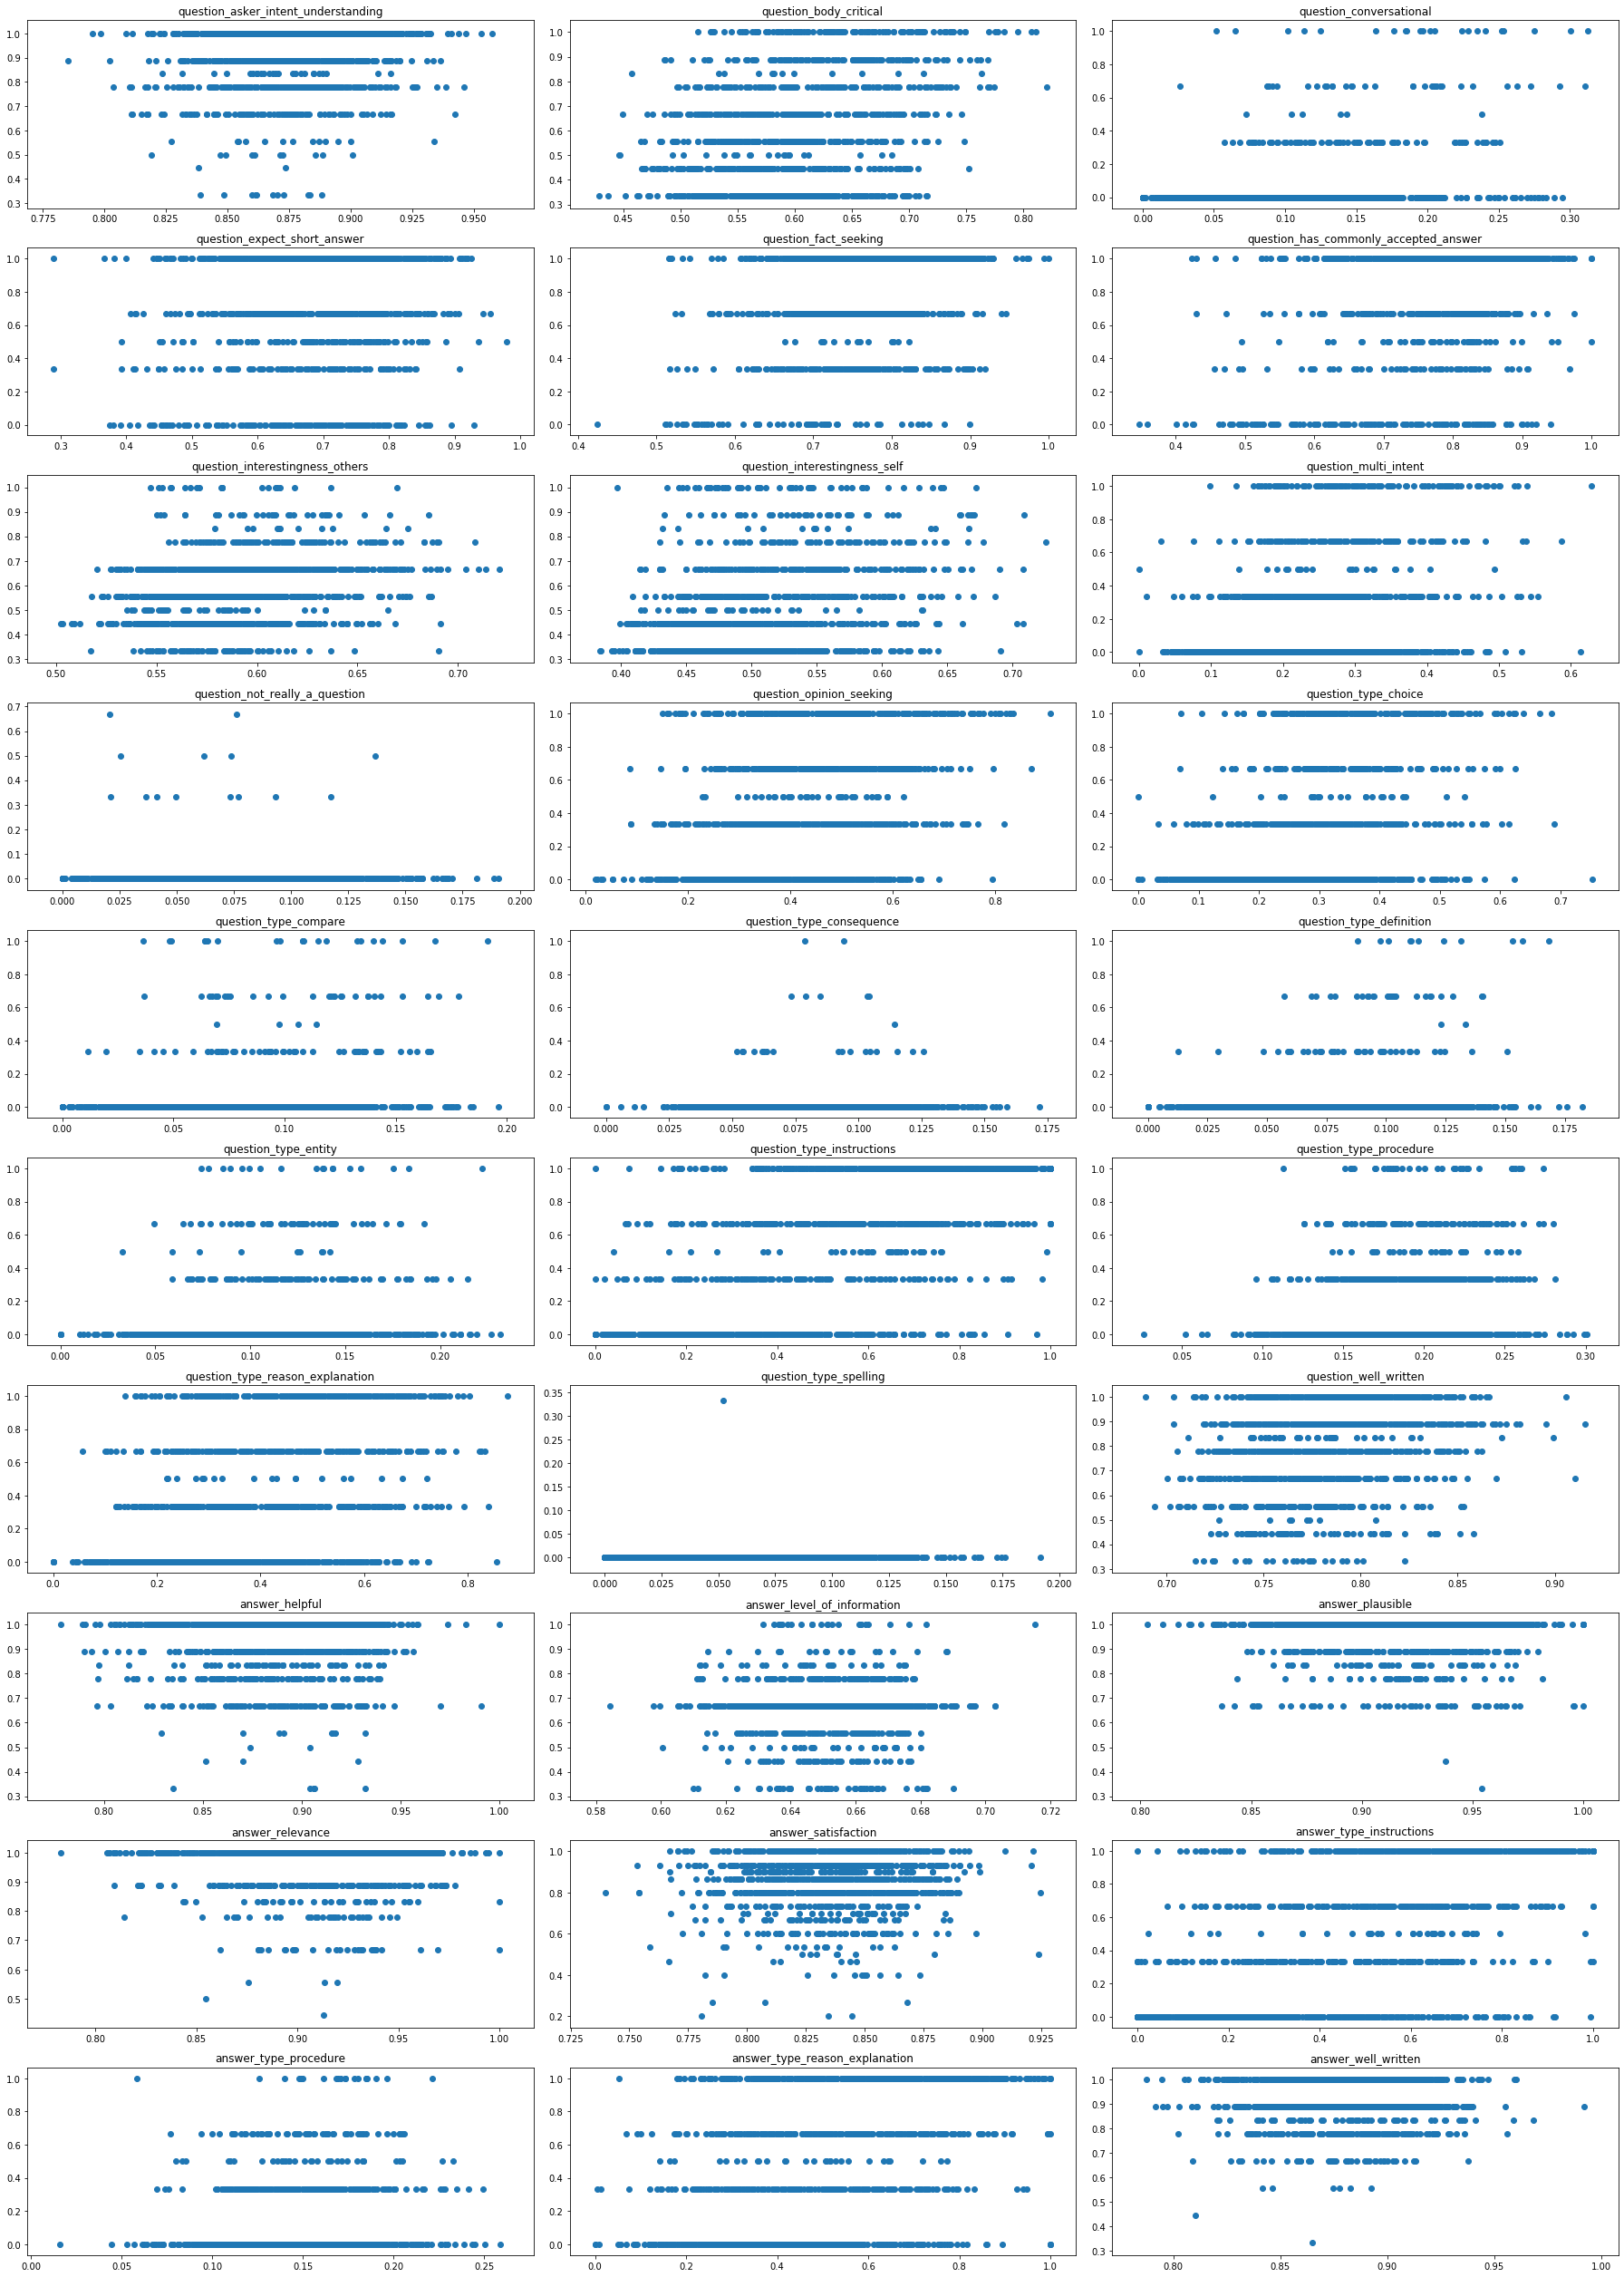

In [58]:
scatterplots(target_names, preds_test, y_test)

# Adding attention layer before LSTM

Luong style, performing self attention on questions and answers. This way, input embeddings get contextualized.

In [60]:
embedding = keras.layers.Embedding(8277, 64)

input_q = keras.layers.Input(shape=500)
x_q = embedding(input_q)
x_q = keras.layers.Attention()([x_q,x_q])
x_q = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(x_q)

input_a = keras.layers.Input(shape=500)
x_a = embedding(input_a)
x_a = keras.layers.Attention()([x_a,x_a])
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(x_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(64, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [61]:
model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 500, 64)      529728      input_23[0][0]                   
                                                                 input_24[0][0]                   
__________________________________________________________________________________________________
attention_1 (Attention)         (None, 500, 64)      0           embedding_12[0][0]   

In [62]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 9s 259ms/step - loss: 0.1508 - val_loss: 0.1360
Epoch 2/500
34/34 [==============================] - 8s 237ms/step - loss: 0.1230 - val_loss: 0.1127
Epoch 3/500
34/34 [==============================] - 8s 240ms/step - loss: 0.1045 - val_loss: 0.0990
Epoch 4/500
34/34 [==============================] - 8s 236ms/step - loss: 0.0938 - val_loss: 0.0909
Epoch 5/500
34/34 [==============================] - 8s 237ms/step - loss: 0.0870 - val_loss: 0.0856
Epoch 6/500
34/34 [==============================] - 8s 241ms/step - loss: 0.0821 - val_loss: 0.0811
Epoch 7/500
34/34 [==============================] - 8s 240ms/step - loss: 0.0780 - val_loss: 0.0778
Epoch 8/500
34/34 [==============================] - 8s 241ms/step - loss: 0.0747 - val_loss: 0.0751
Epoch 9/500
34/34 [==============================] - 8s 237ms/step - loss: 0.0717 - val_loss: 0.0720
Epoch 10/500
34/34 [==============================] - 8s 235ms/step - loss: 0.0688 - val_lo

In [63]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [64]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.085,    mse: 0.018
question_body_critical:                  cor: 0.36,    mse: 0.042
question_conversational:                 cor: 0.37,    mse: 0.03
question_expect_short_answer:            cor: 0.202,    mse: 0.119
question_fact_seeking:                   cor: 0.233,    mse: 0.082
question_has_commonly_accepted_answer:   cor: 0.344,    mse: 0.097
question_interestingness_others:         cor: 0.301,    mse: 0.017
question_interestingness_self:           cor: 0.385,    mse: 0.03
question_multi_intent:                   cor: 0.321,    mse: 0.1
question_not_really_a_question:          cor: 0.015,    mse: 0.006
question_opinion_seeking:                cor: 0.342,    mse: 0.121
question_type_choice:                    cor: 0.268,    mse: 0.13
question_type_compare:                   cor: 0.253,    mse: 0.029
question_type_consequence:               cor: 0.038,    mse: 0.008
question_type_definition:                cor: 0.149,    mse: 0.023
qu

In [65]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.192,    mse: 0.017
question_body_critical:                  cor: 0.451,    mse: 0.039
question_conversational:                 cor: 0.424,    mse: 0.025
question_expect_short_answer:            cor: 0.427,    mse: 0.105
question_fact_seeking:                   cor: 0.424,    mse: 0.074
question_has_commonly_accepted_answer:   cor: 0.566,    mse: 0.078
question_interestingness_others:         cor: 0.312,    mse: 0.017
question_interestingness_self:           cor: 0.411,    mse: 0.029
question_multi_intent:                   cor: 0.481,    mse: 0.088
question_not_really_a_question:          cor: 0.05,    mse: 0.006
question_opinion_seeking:                cor: 0.651,    mse: 0.09
question_type_choice:                    cor: 0.392,    mse: 0.116
question_type_compare:                   cor: 0.249,    mse: 0.022
question_type_consequence:               cor: 0.109,    mse: 0.008
question_type_definition:                cor: 0.176,    mse: 0.0

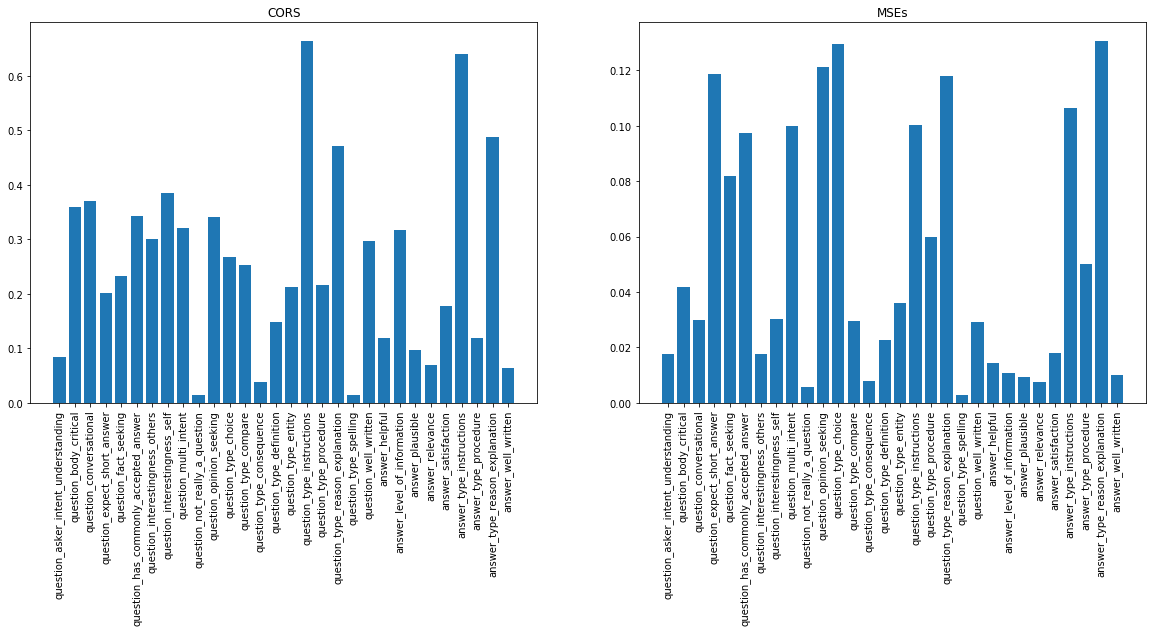

In [67]:
plot_cors_mse(target_names, preds_test, y_test)

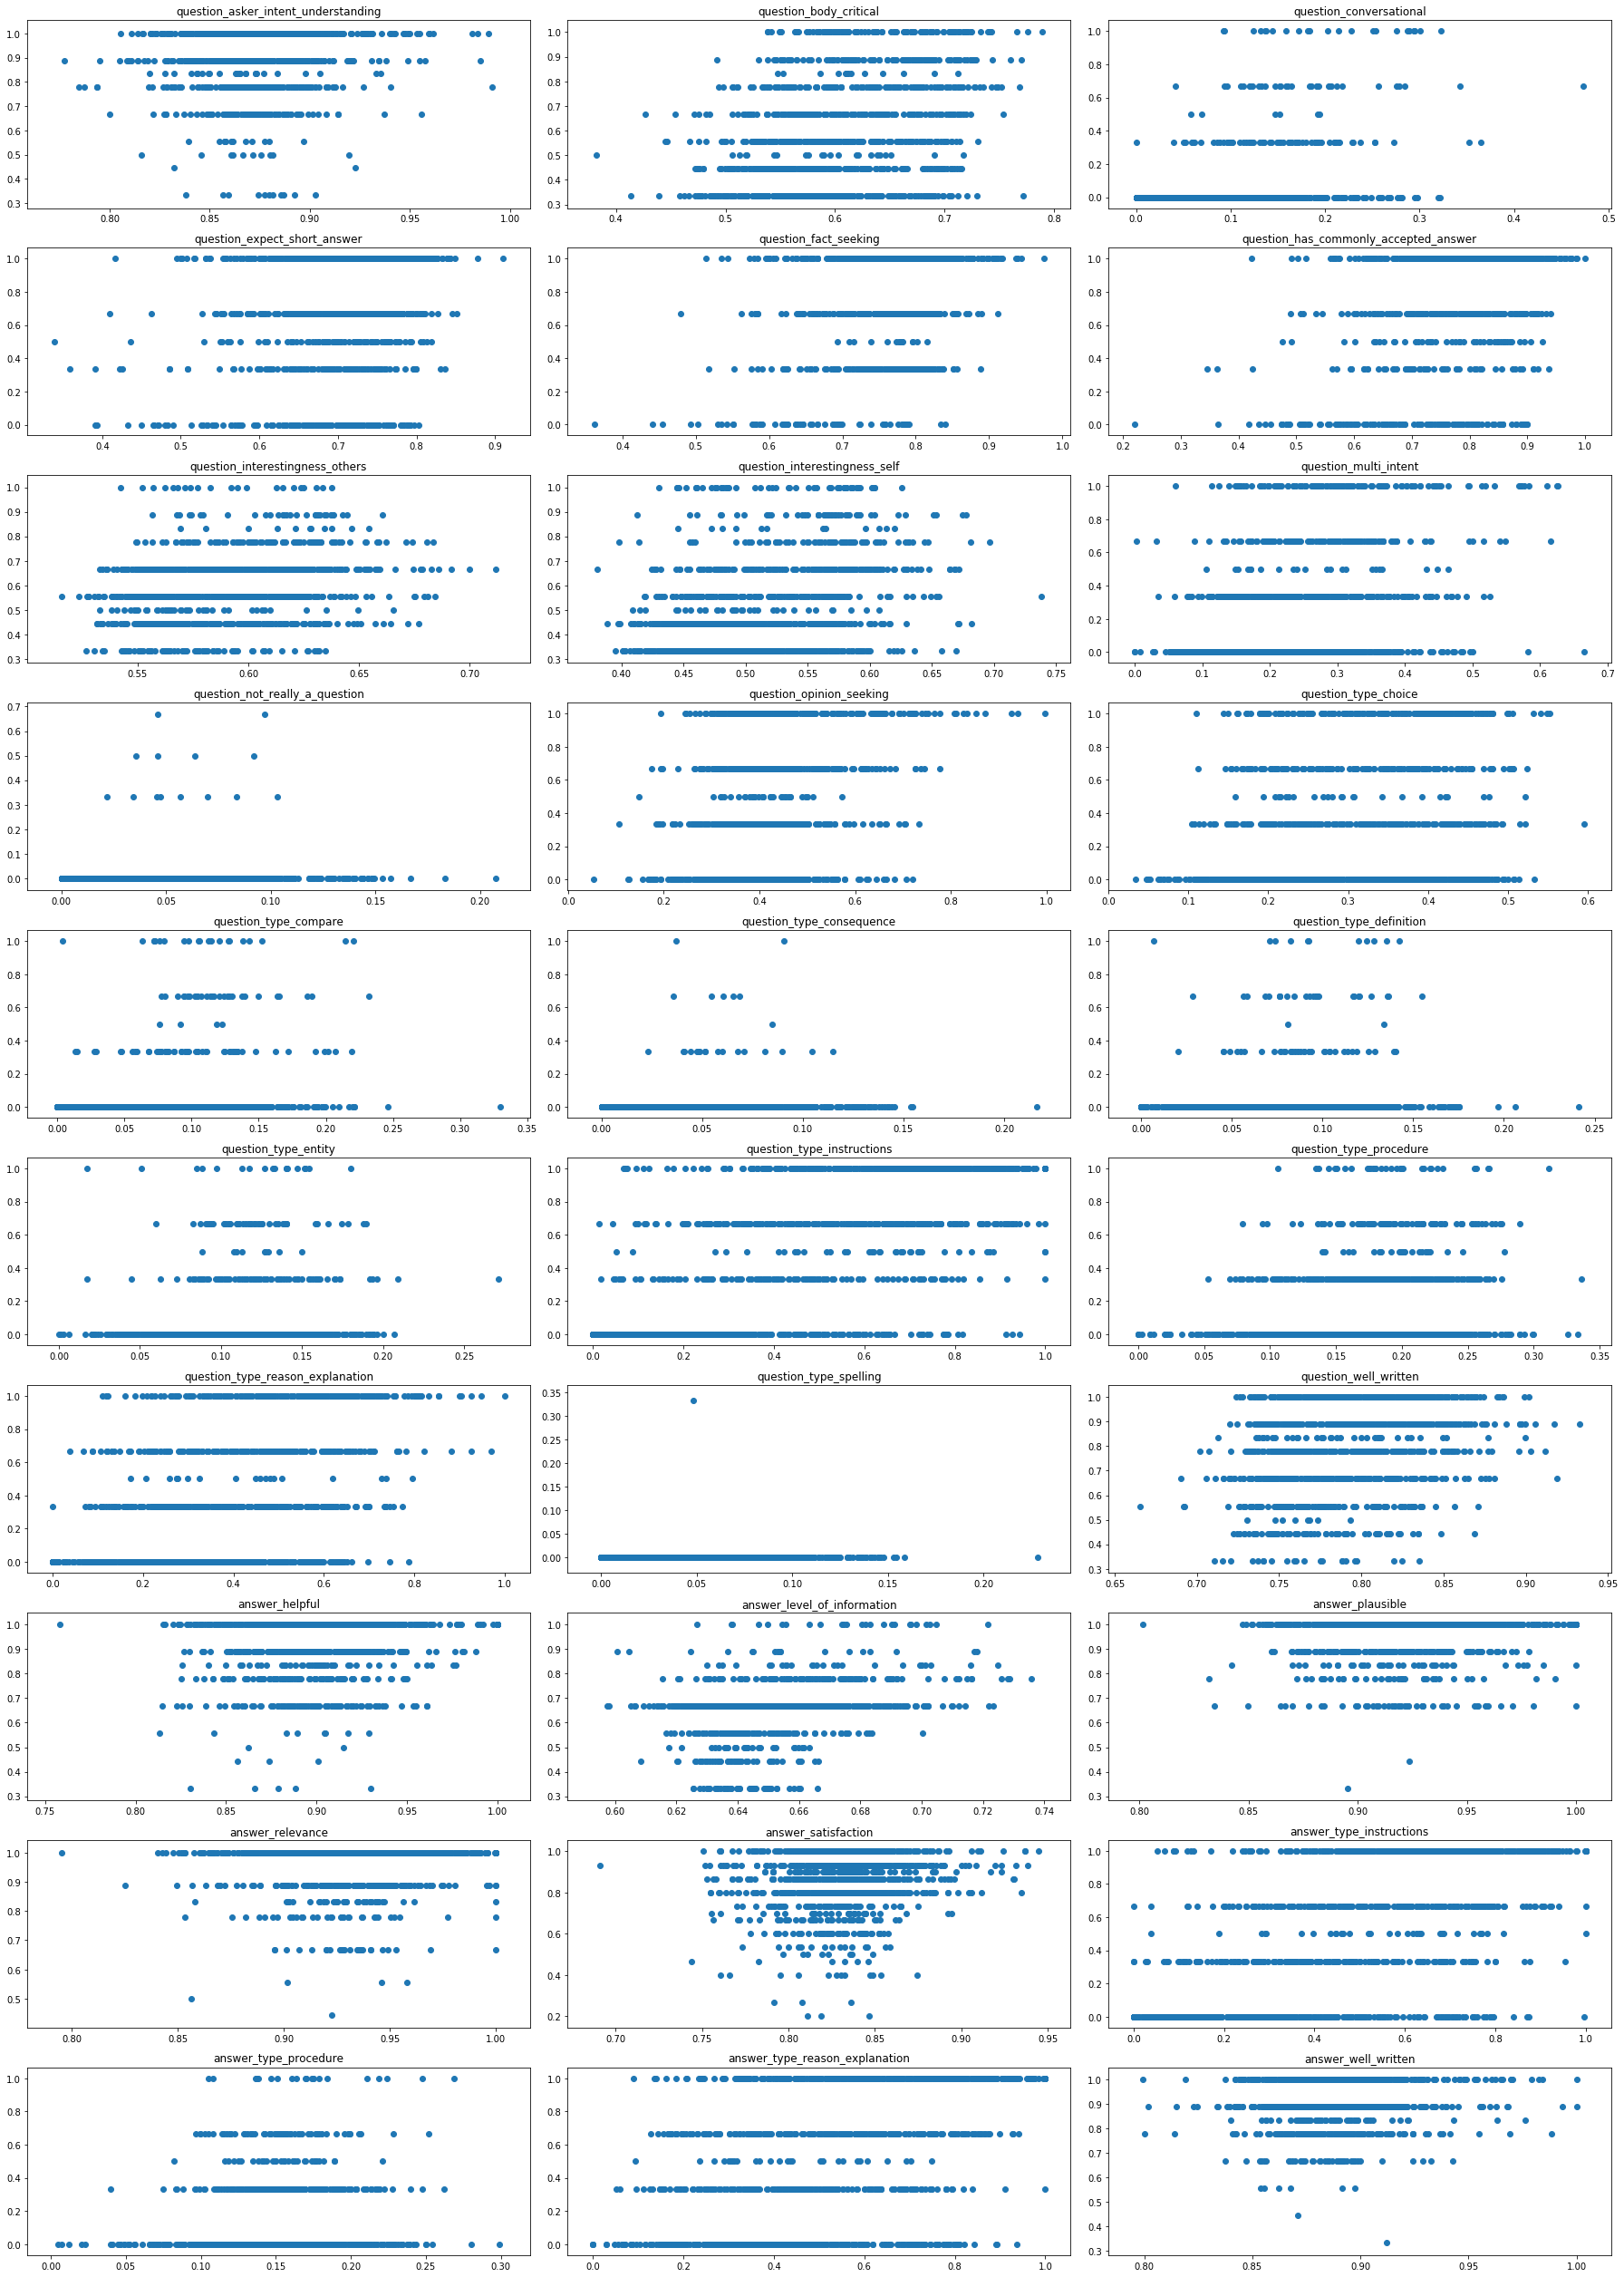

In [68]:
scatterplots(target_names, preds_test, y_test)

# Using sequences from LSTMs

Self attention. But, we need to put time distributed data in just one point, to get predictions. So, adding custom attention layer, which takes all time ponts, and returns their weighted sum. This result is then used in further modeling (many:1 relation).

In [74]:
import tensorflow.keras.backend as K

class attention_many_to_one(keras.layers.Layer):

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        #super().build(input_shape)

    def call(self,x):
        # like time-distributed dense
        # each time point has 64 features
        # takes dot of features with weights (weights have dim 64)
        # returns vector of len 30 - for each timepoint, just one value is returned
        # squeezed from (30,1) to 30
        dots=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        softmax_weights=K.softmax(dots)
        softmax_weights=K.expand_dims(softmax_weights,axis=-1)
        # each time point is miltiplied by corresponding scalar
        # this gives greater weight to more important words in output sequence
        output=x*softmax_weights
        # all 30 time ponts are summed to get just one vector of dim 64
        return K.sum(output,axis=1)

In [83]:
embedding = keras.layers.Embedding(8277, 64)

input_q = keras.layers.Input(shape=500)
x_q = embedding(input_q)
x_q = keras.layers.Attention()([x_q,x_q])
x_q = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True))(x_q)
x_q = attention_many_to_one()(x_q)

input_a = keras.layers.Input(shape=500)
x_a = embedding(input_a)
x_a = keras.layers.Attention()([x_a,x_a])
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True))(x_a)
x_a = attention_many_to_one()(x_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(64, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [84]:
model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 500, 64)      529728      input_35[0][0]                   
                                                                 input_36[0][0]                   
__________________________________________________________________________________________________
attention_13 (Attention)        (None, 500, 64)      0           embedding_19[0][0]   

In [85]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 10s 287ms/step - loss: 0.1538 - val_loss: 0.1395
Epoch 2/500
34/34 [==============================] - 8s 245ms/step - loss: 0.1264 - val_loss: 0.1159
Epoch 3/500
34/34 [==============================] - 8s 246ms/step - loss: 0.1073 - val_loss: 0.1015
Epoch 4/500
34/34 [==============================] - 8s 247ms/step - loss: 0.0960 - val_loss: 0.0927
Epoch 5/500
34/34 [==============================] - 8s 243ms/step - loss: 0.0888 - val_loss: 0.0871
Epoch 6/500
34/34 [==============================] - 9s 254ms/step - loss: 0.0837 - val_loss: 0.0828
Epoch 7/500
34/34 [==============================] - 9s 255ms/step - loss: 0.0797 - val_loss: 0.0791
Epoch 8/500
34/34 [==============================] - 9s 255ms/step - loss: 0.0761 - val_loss: 0.0761
Epoch 9/500
34/34 [==============================] - 9s 257ms/step - loss: 0.0733 - val_loss: 0.0740
Epoch 10/500
34/34 [==============================] - 9s 252ms/step - loss: 0.0703 - val_l

In [86]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [87]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.11,    mse: 0.018
question_body_critical:                  cor: 0.351,    mse: 0.043
question_conversational:                 cor: 0.368,    mse: 0.031
question_expect_short_answer:            cor: 0.154,    mse: 0.121
question_fact_seeking:                   cor: 0.239,    mse: 0.083
question_has_commonly_accepted_answer:   cor: 0.35,    mse: 0.099
question_interestingness_others:         cor: 0.306,    mse: 0.018
question_interestingness_self:           cor: 0.363,    mse: 0.031
question_multi_intent:                   cor: 0.302,    mse: 0.102
question_not_really_a_question:          cor: 0.017,    mse: 0.007
question_opinion_seeking:                cor: 0.353,    mse: 0.123
question_type_choice:                    cor: 0.256,    mse: 0.131
question_type_compare:                   cor: 0.199,    mse: 0.031
question_type_consequence:               cor: 0.044,    mse: 0.009
question_type_definition:                cor: 0.133,    mse: 0.0

In [88]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.231,    mse: 0.018
question_body_critical:                  cor: 0.374,    mse: 0.042
question_conversational:                 cor: 0.413,    mse: 0.027
question_expect_short_answer:            cor: 0.322,    mse: 0.112
question_fact_seeking:                   cor: 0.411,    mse: 0.078
question_has_commonly_accepted_answer:   cor: 0.5,    mse: 0.086
question_interestingness_others:         cor: 0.297,    mse: 0.017
question_interestingness_self:           cor: 0.389,    mse: 0.03
question_multi_intent:                   cor: 0.431,    mse: 0.095
question_not_really_a_question:          cor: 0.042,    mse: 0.007
question_opinion_seeking:                cor: 0.586,    mse: 0.104
question_type_choice:                    cor: 0.364,    mse: 0.119
question_type_compare:                   cor: 0.208,    mse: 0.023
question_type_consequence:               cor: 0.063,    mse: 0.01
question_type_definition:                cor: 0.186,    mse: 0.02


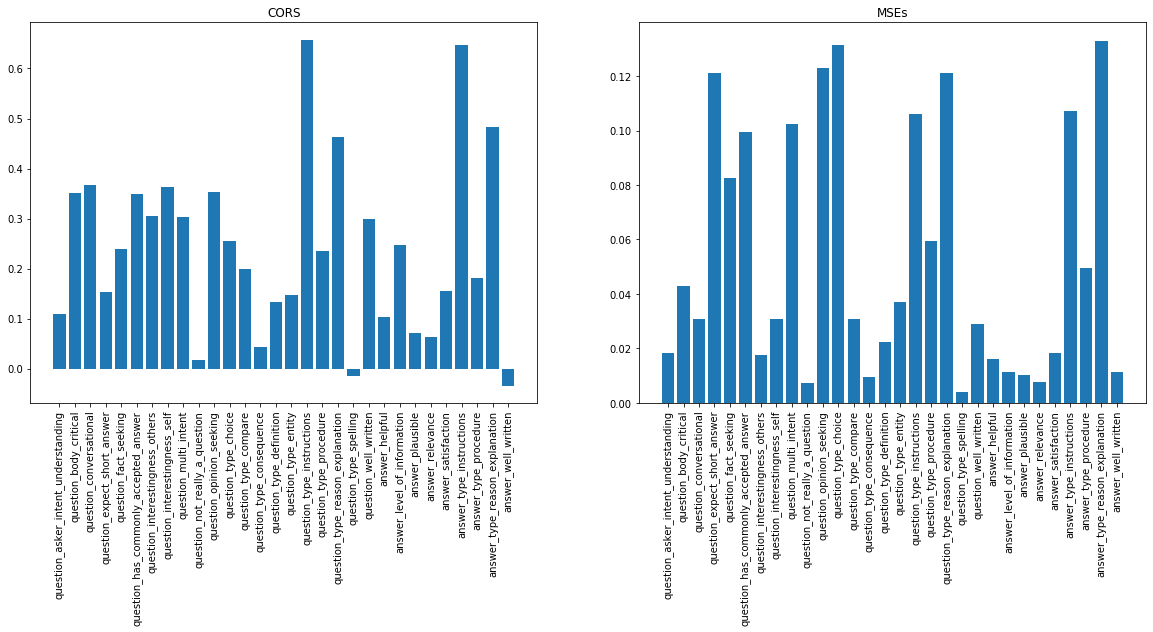

In [89]:
plot_cors_mse(target_names, preds_test, y_test)

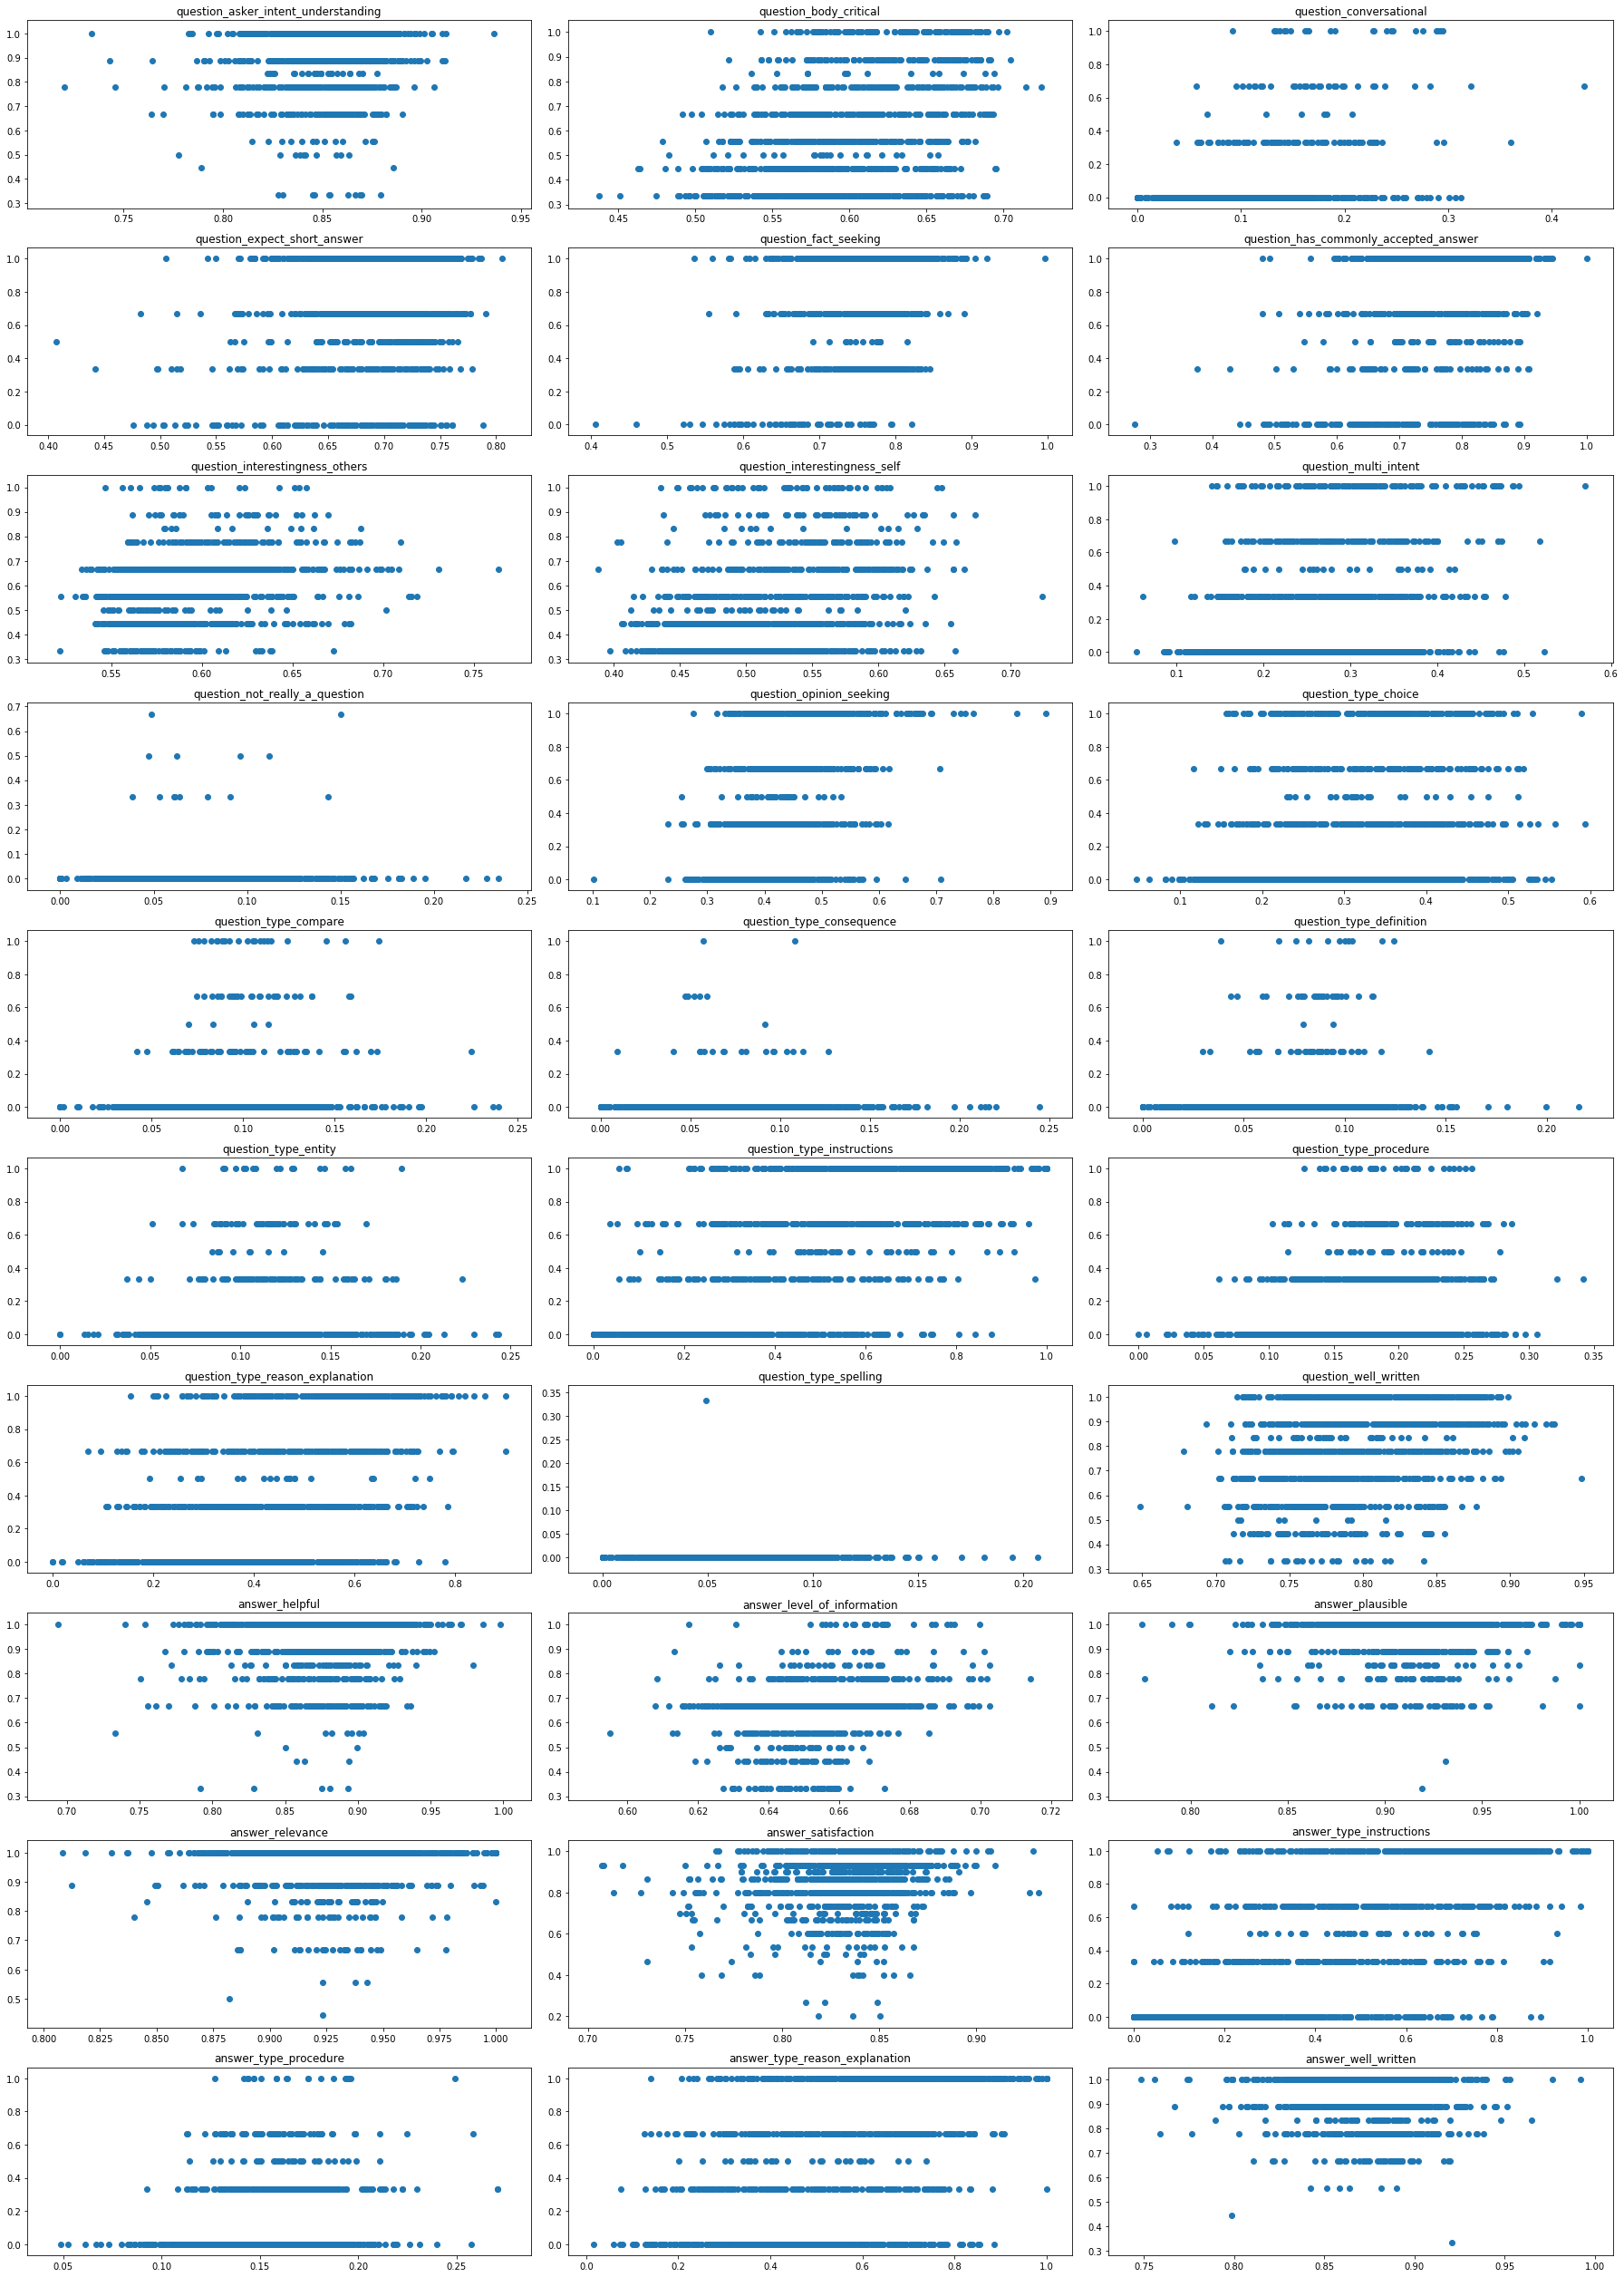

In [90]:
scatterplots(target_names, preds_test, y_test)

# Attention after LSTM

In [91]:
embedding = keras.layers.Embedding(8277, 64)

input_q = keras.layers.Input(shape=500)
x_q = embedding(input_q)
x_q = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True))(x_q)
x_q = keras.layers.Attention()([x_q,x_q])
x_q = attention_many_to_one()(x_q)

input_a = keras.layers.Input(shape=500)
x_a = embedding(input_a)
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True))(x_a)
x_a = keras.layers.Attention()([x_a,x_a])
x_a = attention_many_to_one()(x_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(64, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [92]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 10s 297ms/step - loss: 0.1518 - val_loss: 0.1375
Epoch 2/500
34/34 [==============================] - 9s 272ms/step - loss: 0.1246 - val_loss: 0.1146
Epoch 3/500
34/34 [==============================] - 9s 272ms/step - loss: 0.1061 - val_loss: 0.1006
Epoch 4/500
34/34 [==============================] - 9s 271ms/step - loss: 0.0951 - val_loss: 0.0920
Epoch 5/500
34/34 [==============================] - 9s 265ms/step - loss: 0.0881 - val_loss: 0.0864
Epoch 6/500
34/34 [==============================] - 9s 259ms/step - loss: 0.0832 - val_loss: 0.0823
Epoch 7/500
34/34 [==============================] - 9s 260ms/step - loss: 0.0795 - val_loss: 0.0795
Epoch 8/500
34/34 [==============================] - 9s 259ms/step - loss: 0.0762 - val_loss: 0.0760
Epoch 9/500
34/34 [==============================] - 9s 259ms/step - loss: 0.0731 - val_loss: 0.0739
Epoch 10/500
34/34 [==============================] - 9s 260ms/step - loss: 0.0704 - val_l

In [93]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.11,    mse: 0.018
question_body_critical:                  cor: 0.351,    mse: 0.043
question_conversational:                 cor: 0.368,    mse: 0.031
question_expect_short_answer:            cor: 0.154,    mse: 0.121
question_fact_seeking:                   cor: 0.239,    mse: 0.083
question_has_commonly_accepted_answer:   cor: 0.35,    mse: 0.099
question_interestingness_others:         cor: 0.306,    mse: 0.018
question_interestingness_self:           cor: 0.363,    mse: 0.031
question_multi_intent:                   cor: 0.302,    mse: 0.102
question_not_really_a_question:          cor: 0.017,    mse: 0.007
question_opinion_seeking:                cor: 0.353,    mse: 0.123
question_type_choice:                    cor: 0.256,    mse: 0.131
question_type_compare:                   cor: 0.199,    mse: 0.031
question_type_consequence:               cor: 0.044,    mse: 0.009
question_type_definition:                cor: 0.133,    mse: 0.0

In [94]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.231,    mse: 0.018
question_body_critical:                  cor: 0.374,    mse: 0.042
question_conversational:                 cor: 0.413,    mse: 0.027
question_expect_short_answer:            cor: 0.322,    mse: 0.112
question_fact_seeking:                   cor: 0.411,    mse: 0.078
question_has_commonly_accepted_answer:   cor: 0.5,    mse: 0.086
question_interestingness_others:         cor: 0.297,    mse: 0.017
question_interestingness_self:           cor: 0.389,    mse: 0.03
question_multi_intent:                   cor: 0.431,    mse: 0.095
question_not_really_a_question:          cor: 0.042,    mse: 0.007
question_opinion_seeking:                cor: 0.586,    mse: 0.104
question_type_choice:                    cor: 0.364,    mse: 0.119
question_type_compare:                   cor: 0.208,    mse: 0.023
question_type_consequence:               cor: 0.063,    mse: 0.01
question_type_definition:                cor: 0.186,    mse: 0.02


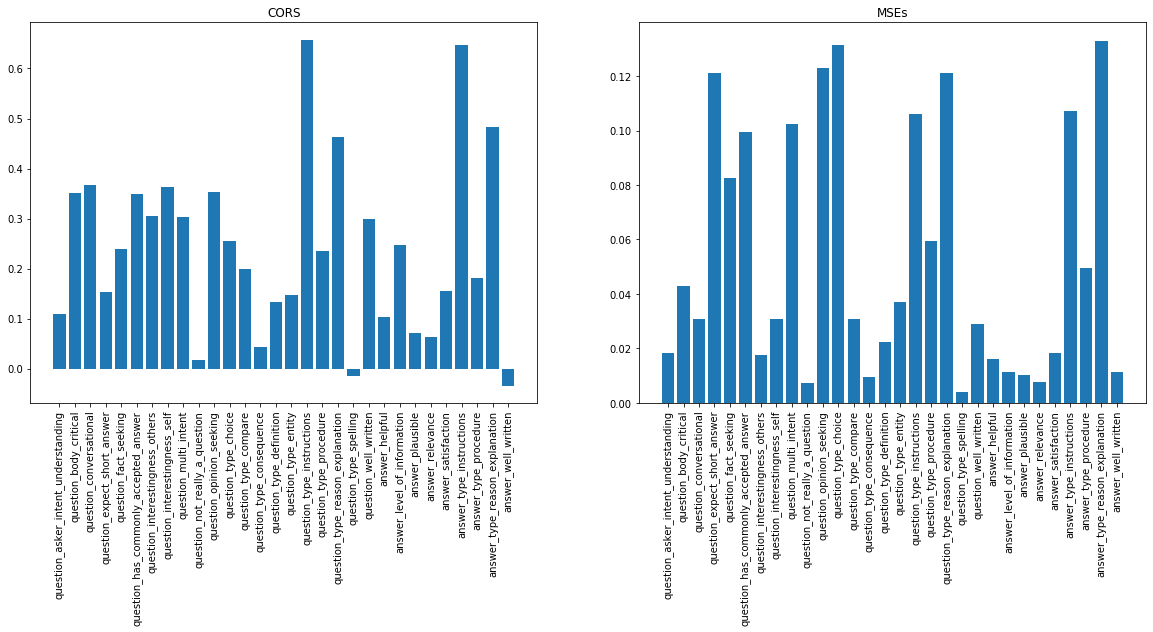

In [95]:
plot_cors_mse(target_names, preds_test, y_test)

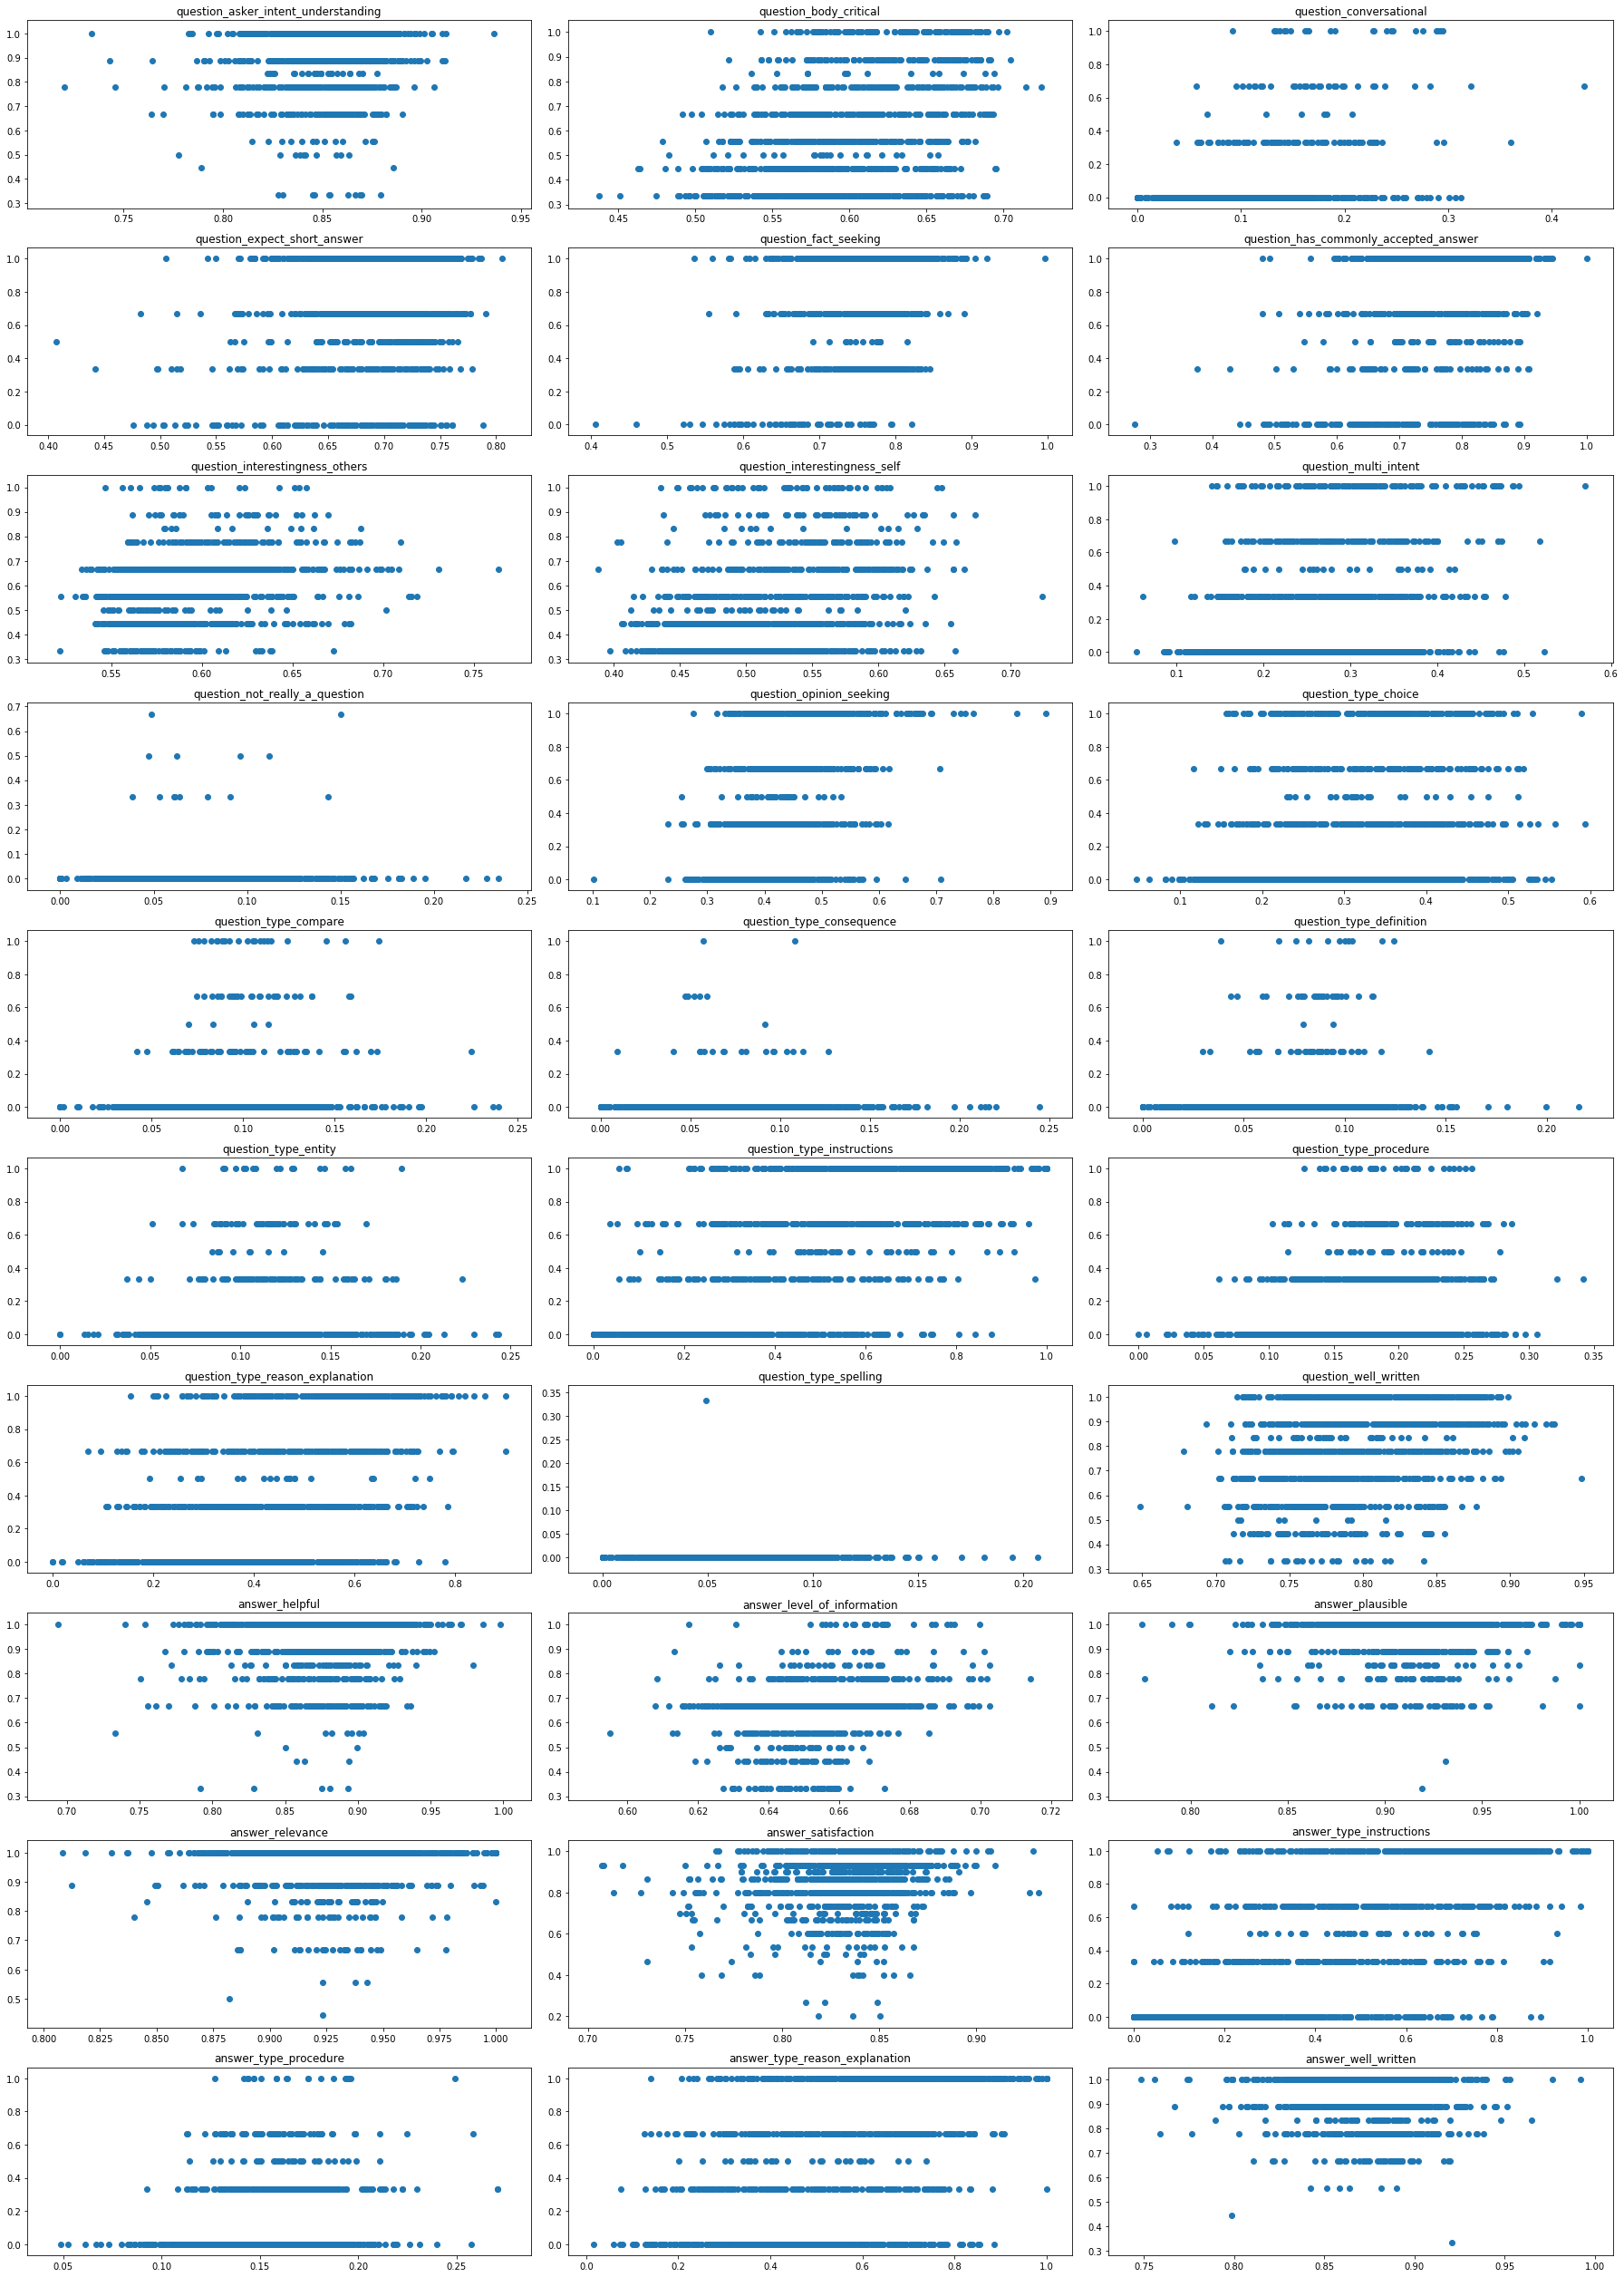

In [96]:
scatterplots(target_names, preds_test, y_test)

In [1]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [2]:
vecs = load_vectors('/home/ksaver/Desktop/wiki-news-300d-1M.vec')

In [14]:
list(vecs['dog'])

[-0.0886,
 0.0351,
 0.0392,
 0.157,
 -0.0276,
 0.0024,
 -0.0751,
 -0.0931,
 0.101,
 -0.0021,
 0.0593,
 0.011,
 0.173,
 0.0563,
 0.0255,
 0.0232,
 0.1158,
 0.0422,
 0.0608,
 -0.1078,
 -0.1808,
 0.0434,
 -0.1358,
 0.0734,
 -0.135,
 0.0279,
 -0.0197,
 0.1795,
 -0.1206,
 0.0445,
 0.0758,
 -0.1076,
 0.0146,
 0.0842,
 -0.2139,
 -0.0645,
 0.048,
 0.0393,
 0.0563,
 0.0282,
 -0.0682,
 0.2524,
 -0.0416,
 -0.0099,
 -0.0713,
 -0.0426,
 0.0657,
 -0.1421,
 0.0092,
 -0.1495,
 0.1142,
 -0.1868,
 -0.6275,
 -0.0909,
 -0.0785,
 -0.0113,
 -0.0015,
 0.1011,
 0.0343,
 -0.0804,
 0.0948,
 -0.0825,
 -0.1163,
 -0.1611,
 -0.0326,
 -0.0684,
 0.0796,
 -0.19,
 -0.0753,
 0.1507,
 -0.1954,
 -0.0249,
 0.0789,
 0.0871,
 0.0023,
 0.0086,
 -0.0396,
 -0.0122,
 -0.0128,
 0.0827,
 0.0177,
 0.1033,
 0.0202,
 -0.22,
 -0.0233,
 0.2281,
 0.1409,
 -0.2303,
 0.2745,
 -0.1925,
 0.0693,
 -0.1065,
 0.0577,
 -0.0929,
 -0.2423,
 0.1033,
 -0.0945,
 0.1362,
 0.0495,
 -0.0191,
 -0.1957,
 0.2158,
 -0.0564,
 -0.1517,
 0.015,
 0.0557,
 -0.0